#### Download dataset

In [1]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('snehilsanyal/construction-site-safety-image-dataset-roboflow', path='D:/Downloads/1517_dataset', unzip=True)

# print("Dataset downloaded and extracted!")

#### load data

In [2]:
import os
import glob
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

label_descriptions = {
    0: "Hardhat",
    1: "Mask",
    2: "NO-Hardhat",
    3: "NO-Mask",
    4: "NO-Safety Vest",
    5: "Person",
    6: "Safety Cone",
    7: "Safety Vest",
    8: "Machinery",
    9: "Vehicle"
}

def get_image_label_pairs(folder):
    images_path = os.path.join(folder, 'images')
    labels_path = os.path.join(folder, 'labels')
    image_files = glob.glob(os.path.join(images_path, '*.jpg'))
    pairs = []
    for image_file in image_files:
        filename = os.path.basename(image_file)
        label_file = os.path.join(labels_path, os.path.splitext(filename)[0] + '.txt')
        if os.path.exists(label_file):
            pairs.append((image_file, label_file))
    return pairs

dataset_path = r'D:\Downloads\1517_dataset\css-data'

train_pairs = get_image_label_pairs(os.path.join(dataset_path, 'train'))
valid_pairs = get_image_label_pairs(os.path.join(dataset_path, 'valid'))
test_pairs = get_image_label_pairs(os.path.join(dataset_path, 'test'))

print(f"Number of training images: {len(train_pairs)}")
print(f"Number of validation images: {len(valid_pairs)}")
print(f"Number of test images: {len(test_pairs)}")

Number of training images: 2605
Number of validation images: 114
Number of test images: 82


### EDA

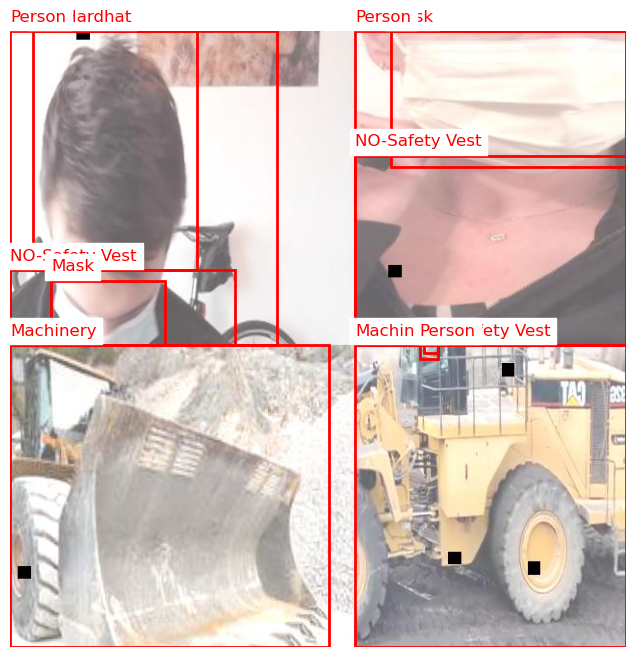

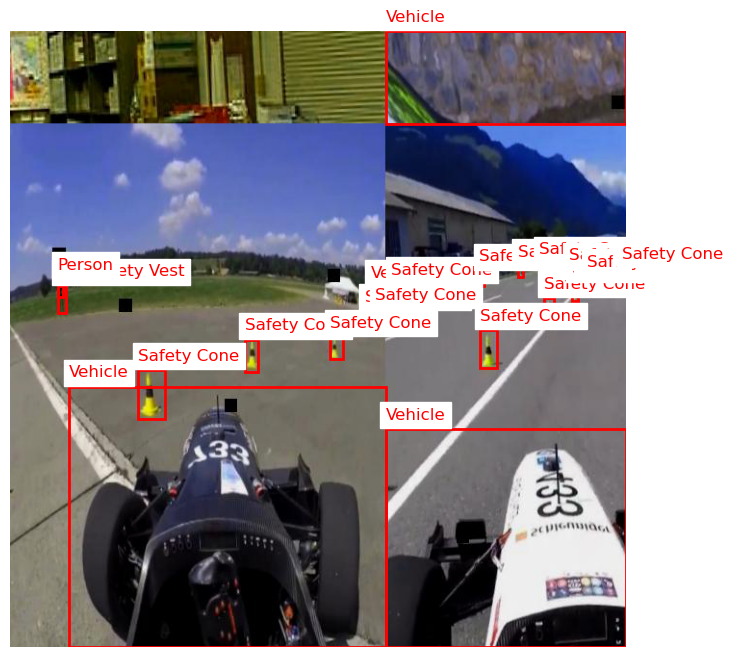

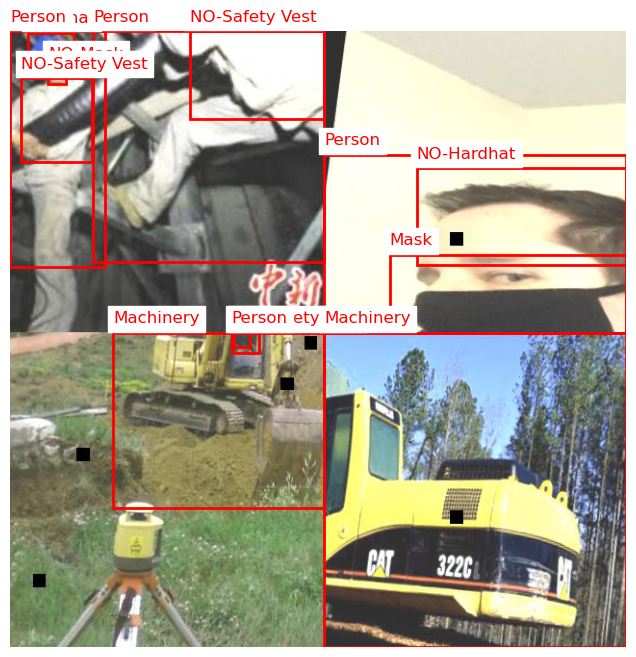

In [3]:
def read_labels(label_file):
    labels = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                bbox = list(map(float, parts[1:]))
                labels.append((class_id, bbox))
    return labels

def plot_image_with_boxes(image_file, label_file):
    image = Image.open(image_file)
    labels = read_labels(label_file)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)
    img_width, img_height = image.size

    for class_id, bbox in labels:
        x_center, y_center, width, height = bbox
        # normalized coordinates to pixel coordinates
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        # top left corner of the bounding box
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        # rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        # class label
        ax.text(x_min, y_min - 10, label_descriptions[class_id],
                color='red', fontsize=12, backgroundcolor='white')
    plt.axis('off')
    plt.show()


random.seed(1234)
sample_pairs = random.sample(train_pairs, 3)

for image_file, label_file in sample_pairs:
    plot_image_with_boxes(image_file, label_file)


In [4]:
def filter_hardhat_data(pairs):
    filtered_pairs = []
    for image_file, label_file in pairs:
        labels = read_labels(label_file)
        class_ids = [class_id for class_id, _ in labels]
        if 5 in class_ids and (0 in class_ids or 2 in class_ids):
            filtered_pairs.append((image_file, label_file))
    return filtered_pairs

hardhat_train_pairs = filter_hardhat_data(train_pairs)
hardhat_valid_pairs = filter_hardhat_data(valid_pairs)
hardhat_test_pairs = filter_hardhat_data(test_pairs)

print(f"Number of training images for hardhat task: {len(hardhat_train_pairs)}")
print(f"Number of validation images for hardhat task: {len(hardhat_valid_pairs)}")
print(f"Number of test images for hardhat task: {len(hardhat_test_pairs)}")

Number of training images for hardhat task: 2059
Number of validation images for hardhat task: 73
Number of test images for hardhat task: 50


In [5]:
#  count cases with and without hardhats in each dataset split
def count_hardhat_cases(pairs):
    with_hardhat = 0
    without_hardhat = 0

    for image_file, label_file in pairs:
        labels = read_labels(label_file)
        class_ids = [class_id for class_id, _ in labels]

        if 5 in class_ids:
            if 0 in class_ids:
                with_hardhat += 1
            elif 2 in class_ids:
                without_hardhat += 1

    return with_hardhat, without_hardhat

train_with_hardhat, train_without_hardhat = count_hardhat_cases(hardhat_train_pairs)
valid_with_hardhat, valid_without_hardhat = count_hardhat_cases(hardhat_valid_pairs)
test_with_hardhat, test_without_hardhat = count_hardhat_cases(hardhat_test_pairs)

print("Distribution of Hardhat Cases:")
print(f"Training set - With Hardhat: {train_with_hardhat}, Without Hardhat: {train_without_hardhat}")
print(f"Validation set - With Hardhat: {valid_with_hardhat}, Without Hardhat: {valid_without_hardhat}")
print(f"Test set - With Hardhat: {test_with_hardhat}, Without Hardhat: {test_without_hardhat}")

total_train = train_with_hardhat + train_without_hardhat
total_valid = valid_with_hardhat + valid_without_hardhat
total_test = test_with_hardhat + test_without_hardhat

print("\nProportions of Hardhat Cases:")
print(f"Training set - With Hardhat: {train_with_hardhat / total_train:.2%}, Without Hardhat: {train_without_hardhat / total_train:.2%}")
print(f"Validation set - With Hardhat: {valid_with_hardhat / total_valid:.2%}, Without Hardhat: {valid_without_hardhat / total_valid:.2%}")
print(f"Test set - With Hardhat: {test_with_hardhat / total_test:.2%}, Without Hardhat: {test_without_hardhat / total_test:.2%}")

Distribution of Hardhat Cases:
Training set - With Hardhat: 1310, Without Hardhat: 749
Validation set - With Hardhat: 42, Without Hardhat: 31
Test set - With Hardhat: 29, Without Hardhat: 21

Proportions of Hardhat Cases:
Training set - With Hardhat: 63.62%, Without Hardhat: 36.38%
Validation set - With Hardhat: 57.53%, Without Hardhat: 42.47%
Test set - With Hardhat: 58.00%, Without Hardhat: 42.00%
